# Brain proteome in Alzheimer's and Parkinson's disease

By Tim Woelfle, 27/08/2019

This is an exploratory analysis of the openly available brain proteome dataset by Ping et al., described in their 2018 article: [Ping, L., Duong, D.M., Yin, L., Gearing, M., et al. (2018) *Global quantitative analysis of the human brain proteome in Alzheimer’s and Parkinson’s Disease*. Scientific Data. [Online] 5, 180036. Available from: doi:10.1038/sdata.2018.36.](https://www.nature.com/articles/sdata201836)

It contains mass-spectrometry based proteomes from 40 brain tissue donors: 10 controls, 10 Alzheimer's patients (AD), 10 Parkinson's patients (PD) and 10 patients with both (ADPD). Samples were analyzed from the frontal cortex (Brodmann area 9) and the cingulate gyrus (Brodmann area 24). This exploratory analysis focuses on Alzheimer's Disease and the cingulate gyrus but could be repeated in the same way for Parkinson's Disease and / or the frontal cortex. An overview of most methods used here is given in this [review-paper on statistical OMICS analysis (subscription only)](https://onlinelibrary.wiley.com/doi/abs/10.1002/em.21797).

## Table of contents

1. [Sample overview](#1.-Sample-overview)
    1. [Sex distribution by condition](#1.1-Sex-distribution-by-condition)
    2. [Age at death by condition](#1.2-Age-at-death-by-condition)
2. [Cingulate proteome preprocessing](#2.-Cingulate-proteome-preprocessing)
    1. [Investigate missing values](#2.1-Investigate-missing-values)
    2. [Remove proteins with NAs and normalize](#2.2-Remove-proteins-with-NAs-and-normalize)
3. [Dimensionality reduction](#3.-Dimensionality-reduction)
    1. [Principal component analysis](#3.1-Principal-component-analysis)
    2. [UMAP](#3.2.-UMAP)
    3. [Partial least squares](#3.3.-Partial-least-squares)
4. [Univariate analysis](#4.-Univariate-analysis)
    1. [Multiple univariate linear regression](#4.1-Multiple-univariate-linear-regression)
        1. [Significance tests and volcano plot](#4.1.1-Significance-tests-and-volcano-plot)
        2. [Biological interpretation](#4.1.2-Biological-interpretation)
    2. [Multiple univariate logistic regression](#4.2-Multiple-univariate-logistic-regression)
        1. [Significance tests and volcano plot](#4.2.1-Significance-tests-and-volcano-plot)
        2. [Biological interpretation](#4.2.2-Biological-interpretation)
    3. [Comparison of univariate linear- and logistic-regression results](#4.3-Comparison-of-univariate-linear--and-logistic-regression-results)
5. [Multivariate LASSO logistic regression](#5-Multivariate-LASSO-logistic-regression)
    1. [Test-set performance](#5.1-Test-set-performance)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import umap

import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smm

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

## 1. Sample overview

samples_trait_cingulate.csv is derived  from the second sheet "anterior cingulate gyrus" of [samples trait.xlsx](https://dx.doi.org/10.7303/syn10225995.1)

In [2]:
samples = pd.read_csv("samples_trait_cingulate.csv")
samples.head()

,Case number,Primary neuropathologic diagnosis,Overall CERAD,Braak,PMI (hr),Age of Onset,Age at Death,Duration (yr)2,ApoE Status,Race,Sex
0,OS98-11,AD 1,3,6,6.0,56.0,65,9.0,E4/4,w,f
1,OS00-11,AD 2,3,5,4.0,49.0,55,6.0,E3/3,w,m
2,OS00-32,AD 3,3,6,3.5,55.0,62,7.0,E3/4,w,m
3,OS03-163,AD 4,3,6,4.5,51.0,55,4.0,E3/4,w,f
4,E04-186,AD 5,3,6,7.0,59.0,72,13.0,E3/4,w,f


### 1.1 Sex distribution by condition

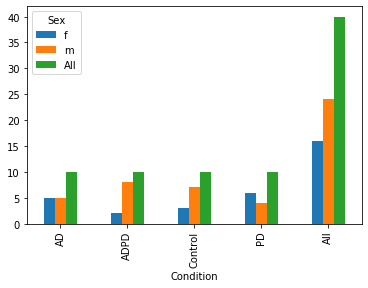

In [3]:
samples["Condition"] = pd.Series(["AD","AD","Control","Control","PD","PD","ADPD","ADPD"]*5)
pd.crosstab(samples.Condition, samples.Sex, margins=True).plot.bar()

### 1.2 Age at death by condition

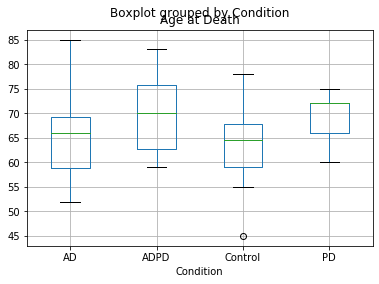

In [4]:
samples.boxplot("Age at Death", by="Condition")

## 2. Cingulate proteome preprocessing

cingulate.csv is derived from the second sheet "anterior cingulate gyrus" of [TMT_Summary_Data.xlsx](https://www.synapse.org/#!Synapse:syn10239444) with the first two rows removed

In [5]:
proteome = pd.read_csv("cingulate_.csv").set_index("Accession")
proteome_dict = proteome.loc[:,"Gene":"Description"]
proteome = proteome.loc[:,"AD1":"ADPD10"].transpose()
proteome.head()

Accession,Q5VT66-2,D6RGC4,Q969Z3,Q9NX47,Q9H992,A6NNE9,Q15019-2,C9IY94,Q9UH03-2,Q9UH03,...,Q8TBC5-3,Q96LW9,A7E2V4-2,S4R3B3,O43264,Q9C0D3,Q15942,O43149,O43149-3,Q8IYH5
AD1,1.124580,0.666667,0.948162,1.067472,NaN,NaN,1.076074,1.148094,0.911617,0.0,...,1.454445,0.877273,1.310105,1.524927,0.942656,1.108474,0.844916,1.002873,1.250597,0.0
AD2,0.881134,0.651515,0.713516,0.932528,NaN,NaN,1.344181,1.336144,0.837435,0.0,...,0.967641,0.759091,1.017422,0.885630,0.930584,0.966762,0.951352,1.005534,1.183771,0.0
CTL1,0.795806,0.621212,0.675168,0.946626,NaN,NaN,1.027415,1.054985,0.736138,0.0,...,1.012096,0.790909,1.486643,3.300098,0.980885,0.831706,0.622753,1.029573,1.031026,0.0
CTL2,0.960637,1.181818,1.090438,0.958711,NaN,NaN,0.874709,0.892595,1.033973,0.0,...,1.170908,1.268182,1.094077,0.838710,1.018360,0.990585,1.248980,1.085847,1.183771,0.0
PD1,1.125191,1.484848,1.186200,1.105740,NaN,NaN,0.854764,0.801320,0.965995,0.0,...,0.556865,5.927273,1.279907,1.090909,1.072435,1.013882,1.336909,0.998395,1.011933,0.0


### 2.1 Investigate missing values

A single value of 0 means the protein was identified but not successfully quantified, if the whole batch is 0 it means that one of the GIS (global internal standards) was missing and the measurement is therefore considered unreliable, see sheet "Key" in [TMT_Summary_Data.xlsx](https://www.synapse.org/#!Synapse:syn10239444). There are 5 batches of 8 subjects each. In either case we consider them NA.

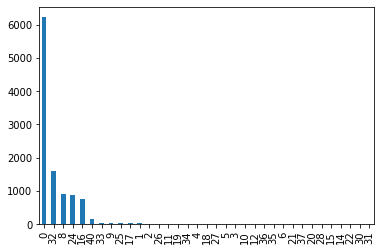

In [6]:
(proteome.isna() | (proteome == 0)).sum().value_counts().plot.bar()

The barplot shows that most proteins with NA values are missing for at least one whole batch (8/16/24/32/40 subjects), so imputation is risky. We try a complete case analysis first, with nearly 60% of all proteins.

In [7]:
(proteome>0).all().sum() / proteome.shape[1]

0.5825151940158952

### 2.2 Remove proteins with NAs and normalize

Normalization to mean 0 and standard deviation 1 per column is important for PCA.

In [8]:
proteome = proteome.loc[:, (proteome>0).all()]
proteome = (proteome - proteome.mean()) / proteome.std()
proteome.head()

Accession,Q5VT66-2,Q969Z3,Q15019-2,C9IY94,Q9UH03-2,Q99719,G3XAH0,Q14141,Q16181-2,Q16181,...,Q14966,Q9Y5V0,Q8NHG8,O75312,Q8TBC5-3,A7E2V4-2,O43264,Q9C0D3,Q15942,O43149
AD1,1.006041,-0.330660,0.585419,0.814268,-0.931852,-0.891949,-1.172335,-0.301688,0.123567,-1.414264,...,0.498701,-1.136658,-0.355748,-1.654166,2.035214,1.657337,-0.670185,1.475818,-0.876639,0.128153
AD2,-0.975074,-1.885644,2.600928,1.950324,-1.731064,-0.763846,-1.704209,-1.885033,0.411533,-0.762315,...,0.934354,0.907615,-0.608691,-1.273378,-0.147662,0.146033,-0.872731,-0.271251,-0.308122,0.157057
CTL1,-1.669458,-2.139778,0.219625,0.251776,-2.822402,-1.984050,-2.551838,-2.368348,-2.718866,-1.922959,...,-1.468940,-0.865875,0.016641,1.134082,0.051678,2.568918,-0.028791,-1.936258,-2.063302,0.418108
CTL2,-0.328097,0.612196,-0.928350,-0.729263,0.386378,0.742056,0.862101,1.205374,0.812045,0.573740,...,-0.371849,-1.600656,-0.608691,-1.474000,0.763807,0.541851,0.599944,0.022447,1.281627,1.029217
PD1,1.011008,1.246803,-1.078290,-1.280682,-0.345995,0.056382,0.034887,0.910110,-0.906297,0.063583,...,2.633783,-0.188916,-0.109831,-1.117601,-1.989617,1.501409,1.507179,0.309666,1.751289,0.079521


Distributions look more or less normal, don't seem to need log-transformation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36cd9dc710>,
      dtype=object)

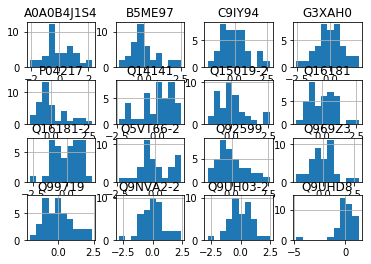

In [9]:
proteome.iloc[:,0:16].hist()

## 3. Dimensionality reduction

### 3.1 Principal component analysis

The first PCA component of the cingulate proteome explains 22.3% of the variance and the second component 13.4%.

[0.18717674 0.10779146]


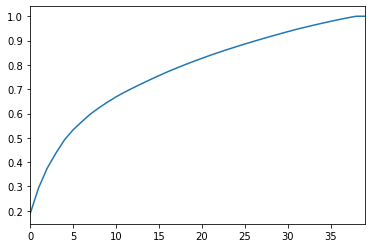

In [10]:
pca_model = PCA()
pca = pca_model.fit_transform(proteome)[:,0:2]
print(pca_model.explained_variance_ratio_[0:2])
pd.Series(np.cumsum(pca_model.explained_variance_ratio_)).plot()

In the PCA plot we can already see that AD+ADPD cluster more to the right whereas Control+PD cluster more to the left. However, these two components only capture roughly 30% of the variance in the data, let's see if UMAP produces a different result.

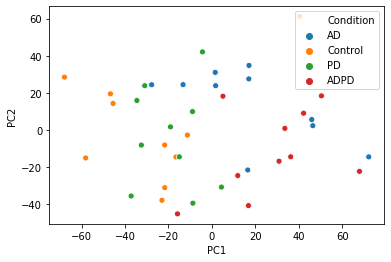

In [11]:
# can't color categorically with pandas alone, so use seaborn
#pd.DataFrame(pca, columns=["PC1", "PC2"]).plot.scatter(x="PC1", y="PC2")
sns.scatterplot("PC1", "PC2", data=pd.DataFrame(pca, columns=["PC1", "PC2"]),
                hue=samples.Condition)

### 3.2. UMAP

UMAP is a modern dimensionality reduction technique similar to t-SNE, able to shrink all of the data to two components. See more details here: https://github.com/lmcinnes/umap

Again, we can already appreciate that AD+ADPD seem to cluster together (top-right) whereas Control+PD seem to be clustered more in the bottom-left.

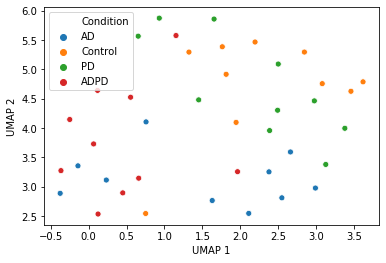

In [12]:
embedding = umap.UMAP().fit_transform(proteome)
sns.scatterplot("UMAP 1", "UMAP 2", data=pd.DataFrame(embedding, columns=["UMAP 1", "UMAP 2"]),
                hue=samples.Condition)

### 3.3. Partial least squares

PLS can be considered both a dimensionality reduction method and a supervised learning algorithm. Whereas PCA & UMAP are agnostic of the outcome variable, PLS is fitting components to maximize variance not just in the input space X (proteome) but also in the outcome space Y, which is a 40x4 binary (dummy) matrix representing Controls, AD, PD & ADPD.

So this plot shows fairly good separability of the four classes when trained on the outcome data but we see that Alzheimer's (AD/ADPD) separates better from controls than does Parkinson's only (PD).

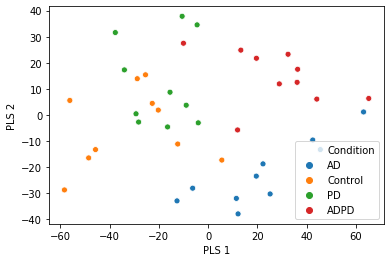

In [13]:
pls = PLSRegression(n_components=2).fit(proteome, pd.get_dummies(samples.Condition))
sns.scatterplot("PLS 1", "PLS 2", data=pd.DataFrame(pls.x_scores_, columns=["PLS 1", "PLS 2"]),
                hue=samples.Condition)

## 4. Univariate analysis

This can be considered a "PWAS", a Proteome Wide Association Study". There are two ways of modelling this: Linear Regression and Logistic Regression

### 4.1 Multiple univariate linear regression

Every protein-quantity is tested as dependent variable against the two binary phenotypes Alzheimer's (including AD and ADPD patients) and Parkinson's (including PD and ADPD patients) in two separate univariate models. Results are saved to AD_univariate_linreg.csv and PD_univariate_linreg.csv

In [14]:
AD = np.array([1,1,0,0,0,0,1,1]*5) # AD, ADPD: True; Control, PD: False
PD = np.array([0,0,0,0,1,1,1,1]*5) # PD, ADPD: True; Control, AD: False

ADuniv = proteome_dict.loc[proteome.columns,:"Gene"]
PDuniv = proteome_dict.loc[proteome.columns,:"Gene"]
for protein in proteome.columns:
    lr = smf.ols("Q('" + protein + "') ~ AD", data=proteome).fit()
    ADuniv.loc[protein, "coef"] = lr.params[1]
    ADuniv.loc[protein, "pval"] = lr.pvalues[1]
    lr = smf.ols("Q('" + protein + "') ~ PD", data=proteome).fit()
    PDuniv.loc[protein, "coef"] = lr.params[1]
    PDuniv.loc[protein, "pval"] = lr.pvalues[1]

# Sort outcome by p-value
ADuniv = ADuniv.sort_values("pval")
PDuniv = PDuniv.sort_values("pval")

ADuniv.to_csv("AD_univariate_linreg.csv")
PDuniv.to_csv("PD_univariate_linreg.csv")

In [15]:
ADuniv.head(20)

,Gene,coef,pval
Accession,,,
Q9H4F8-2,SMOC1,1.802782,2.298555e-16
E9PLM6,MDK,1.663440,9.533849e-12
P05067,APP,1.625795,6.988686e-11
A0A087WWT2,NRN1,-1.583374,5.054728e-10
Q99784,OLFM1,-1.546295,2.363332e-09
Q8NAA5,LRRC75A,-1.540159,3.006388e-09
Q96NI6,LRFN5,-1.529536,4.519406e-09
Q14571,ITPR2,1.509881,9.337636e-09
Q96CG8,CTHRC1,1.506727,1.045667e-08


#### 4.1.1 Significance tests and volcano plot

132 proteins are significant after Bonferroni correction, and an additional 1491 after FDR correction. The volcano plot looks U-shaped because the input matrix is normalized to mean 0 and std 1. See [2_compare_univariate_results.ipynb](2_compare_univariate_results.ipynb) and [2_compare_univariate_results.html](2_compare_univariate_results.html) for interactive volcano plots.

In [16]:
ADuniv["Significant"] = "False"
ADuniv.loc[smm.multipletests(ADuniv.pval, method="fdr_bh")[0], "Significant"] = "FDR"
ADuniv.loc[smm.multipletests(ADuniv.pval, method="bonferroni")[0], "Significant"] = "Bonferroni"
ADuniv.loc[:,"Significant"].value_counts()

False         4607
FDR           1491
Bonferroni     132
Name: Significant, dtype: int64

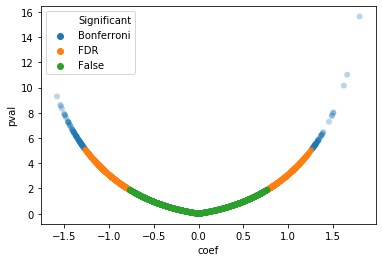

In [17]:
sns.scatterplot(ADuniv.coef, -np.log10(ADuniv.pval), hue=ADuniv["Significant"], edgecolor="none", alpha=0.3)

#### 4.1.2 Biological interpretation

Among the Bonferroni significant top hits are two of Alzheimer's Disease hallmark proteins:

* [Amyloid beta](https://en.wikipedia.org/wiki/Amyloid_beta), encoded by the gene APP, UniProt ID [P05067](https://www.uniprot.org/uniprot/P05067)
* [Tau protein](https://en.wikipedia.org/wiki/Amyloid_beta), encoded by the gene MAPT, UniProt ID [P10636](https://www.uniprot.org/uniprot/P10636)

Another hallmark protein is not significant, probably because only its NAC fragment is associated with Alzheimer's:

* [Alpha synucelin](https://en.wikipedia.org/wiki/Alpha-synuclein), encoded by gene SNCA, UniProt ID [P37840](https://www.uniprot.org/uniprot/P37840)

The most significant protein however, encoded by the [SMOC1 gene, has only recently been associated with Alzheimer's in a proteomic analysis of cerebrospinal fluid](https://alzres.biomedcentral.com/articles/10.1186/s13195-018-0397-4):

* SPARC-related modular calcium-binding protein 1, encoded by SMOC1 gene, UniProt ID [Q9H4F8-2](https://www.uniprot.org/uniprot/Q9H4F8-2)

In [18]:
ADuniv.loc[("Q9H4F8-2", "P05067", "P10636", "P37840"),:]

,Gene,coef,pval,Significant
Accession,,,,
Q9H4F8-2,SMOC1,1.802782,2.298555e-16,Bonferroni
P05067,APP,1.625795,6.988686e-11,Bonferroni
P10636,MAPT,1.379071,5.446650e-07,Bonferroni
P37840,SNCA,-0.408184,2.006676e-01,False


### 4.2 Multiple univariate logistic regression

For performing logistic regression, we need a binary dependent variable. Thus, this time we use AD / PD status as dependent (outcome) variable and protein-quantity as independent (input) variable in two separate univariate models per protein.

In [19]:
ADuniv_log = proteome_dict.loc[proteome.columns,:"Gene"]
PDuniv_log = proteome_dict.loc[proteome.columns,:"Gene"]

for protein in proteome.columns:
#protein = proteome.columns[1]
    AD_logit = smf.logit("AD ~ Q('" + protein + "')", data=proteome).fit(disp=False, method='lbfgs')
    PD_logit = smf.logit("PD ~ Q('" + protein + "')", data=proteome).fit(disp=False, method='lbfgs')
    ADuniv_log.loc[protein, "coef"] = AD_logit.params[1]
    PDuniv_log.loc[protein, "coef"] = PD_logit.params[1]
    ADuniv_log.loc[protein, "pval"] = AD_logit.pvalues[1]
    PDuniv_log.loc[protein, "pval"] = PD_logit.pvalues[1]

# Sort outcome by p-value
ADuniv_log = ADuniv_log.sort_values("pval")
PDuniv_log = PDuniv_log.sort_values("pval")

ADuniv_log.to_csv("AD_univariate_logreg.csv")
PDuniv_log.to_csv("PD_univariate_logreg.csv")

In [20]:
ADuniv_log.head(20)

,Gene,coef,pval
Accession,,,
P05067,APP,3.675193,0.000359
Q9H2M9,RAB3GAP2,-2.282264,0.000484
Q8IV01,SYT12,-2.174953,0.000493
O75116,ROCK2,-3.147778,0.000508
Q9ULR3,PPM1H,-2.247118,0.000516
P01111,NRAS,-2.754446,0.000543
Q96HS1,PGAM5,-2.003476,0.000549
Q15819,UBE2V2,-2.676874,0.000554
P40121,CAPG,2.170653,0.000554


#### 4.2.1 Significance tests and volcano plot

No proteins are significant after Bonferroni correction, but 1016 after FDR correction. See [2_compare_univariate_results.ipynb](2_compare_univariate_results.ipynb) and [2_compare_univariate_results.html](2_compare_univariate_results.html) for interactive volcano plots.

In [21]:
ADuniv_log["Significant"] = "False"
ADuniv_log.loc[smm.multipletests(ADuniv_log.pval, method="fdr_bh")[0], "Significant"] = "FDR"
ADuniv_log.loc[smm.multipletests(ADuniv_log.pval, method="bonferroni")[0], "Significant"] = "Bonferroni"
ADuniv_log.loc[:,"Significant"].value_counts()

False    5214
FDR      1016
Name: Significant, dtype: int64

[(-10, 10)]

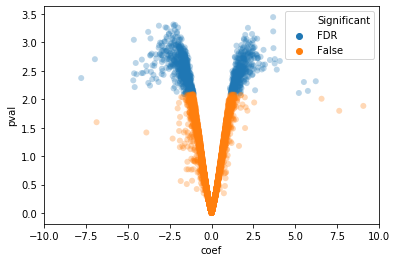

In [22]:
sns.scatterplot(ADuniv_log.coef, -np.log10(ADuniv_log.pval),
                hue=ADuniv_log["Significant"], edgecolor="none", alpha=.3).set(xlim=(-10,10))

#### 4.2.2 Biological interpretation

Similar to the [biological interpretation of linear regression results](#4.1.2-Biological-interpretation), Alzheimer's hallmark proteins Amyloid beta and Tau protein are highly signficant. However, SMOC1 is not significant this time, despite its huge outlier beta-coefficient of 75 (in fact, it's the only outlier not shown in this volcano plot). Closer examination reveals that this is because of perfect separability, as demonstrated in the plot below. In perfect separability cases, logistic regression fails to give meaningful p-values.

In [23]:
ADuniv_log.loc[("Q9H4F8-2", "P05067", "P10636", "P37840"),:]

,Gene,coef,pval,Significant
Accession,,,,
Q9H4F8-2,SMOC1,75.437876,0.677965,False
P05067,APP,3.675193,0.000359,FDR
P10636,MAPT,5.751427,0.007119,FDR
P37840,SNCA,-0.433795,0.199033,False


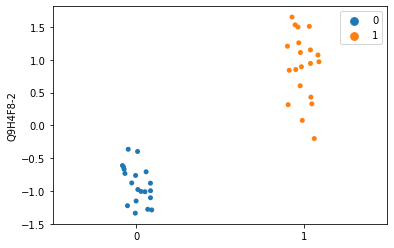

In [24]:
sns.stripplot(AD, proteome["Q9H4F8-2"], hue=AD)

### 4.3 Comparison of univariate linear- and logistic-regression results

It already becomes obvious by comparing the numbers of significant variables that linear-regression seems to be more powerful on this dataset: 132 Bonferroni- and 1623 FDR-significant proteins for linear-regression vs 0 Bonferroni- and 1016 FDR-significant proteins for logistic-regression (at the 0.05 level).

A more detailed interactive comparison of the two results are in the accompanying files [2_compare_univariate_results.ipynb](2_compare_univariate_results.ipynb) and [2_compare_univariate_results.html](2_compare_univariate_results.html).

## 5 Multivariate LASSO logistic regression

Remove SMOC1 (Q9H4F8-2) because of perfect separability. LASSO selects a subset of variables as predictors by penalizing on the L1-Norm of the beta-coefficients. SKLearn's [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) employs cross-validation to identify the optimal lambda (or C) hyperparameter. Below are the selected proteins and their beta coefficients. The training-set size is 30 samples and the test set size is 10 samples.

In [25]:
proteome_reduced = proteome.drop("Q9H4F8-2", axis=1)

X_train, X_test, y_train, y_test = train_test_split(proteome_reduced, AD, test_size=0.25, random_state=1337)

model = LogisticRegressionCV(cv=10, solver="liblinear", penalty="l1", random_state=1337).fit(X_train, y_train)

list(zip(proteome_reduced.columns[(model.coef_!=0)[0]],
         model.coef_[model.coef_!=0]))

[('Q15019-2', 0.07475893865168265),
 ('O75078', -0.050325227951352365),
 ('P05067', 0.17694675093618312),
 ('V9GYM8', -0.07648340129495527),
 ('P00966', 0.191924439342754),
 ('Q9UL15-2', -0.510364224138429),
 ('Q13490', -0.5421988317437187),
 ('Q9P1Z2', -0.03638737562594481),
 ('Q6P1J9', 0.004524336572358402),
 ('P02741', 0.09237296335569202),
 ('H7BYT1', 0.06420940778665873),
 ('Q96CG8', 0.39981851677520247),
 ('Q9UDY4', -0.11248206786135964),
 ('P07099', 0.0007605163156639481),
 ('P13726', 0.04195137694704598),
 ('Q86UX7', 0.07357031570028937),
 ('P60520', -0.0644233709563225),
 ('A6NHX0', -0.3453335016480302),
 ('Q9NZ52', -0.00860676289560626),
 ('Q8NDH6', -0.23816834785355184),
 ('Q14571', 0.0382484527026758),
 ('Q5SVJ7', -0.0004414865014175081),
 ('P18428', 0.006796543792457058),
 ('Q96NI6', -0.30309139344409874),
 ('Q5VZK9', 0.22035565656560557),
 ('Q8NAA5', -0.10402188465951608),
 ('P10636-6', 0.013450968474848817),
 ('E9PLM6', 0.26298961658960146),
 ('Q8WUY8', -0.00659997194464

### 5.1 Test-set performance

In [26]:
# train accuracy + confusion matrix
y_pred_class = model.predict(X_train)
print("Training accuracy:", metrics.accuracy_score(y_train, y_pred_class))
print("Training F1 score:", metrics.f1_score(y_train, y_pred_class))
#print("Log loss:", metrics.log_loss(y_train, y_pred_class))
#print(metrics.confusion_matrix(y_train, y_pred_class).transpose())

# test accuracy + confusion matrix
y_pred_class = model.predict(X_test)
print("Test-set accuracy:", metrics.accuracy_score(y_test, y_pred_class))
print("Test-set F1 score:", metrics.f1_score(y_test, y_pred_class))
#print("Log loss:", metrics.log_loss(y_test, y_pred_class))
#print(metrics.confusion_matrix(y_test, y_pred_class).transpose())

Training accuracy: 1.0
Training F1 score: 1.0
Test-set accuracy: 0.9
Test-set F1 score: 0.8571428571428571
